In [0]:
!sudo pip install git+https://www.github.com/keras-team/keras-contrib.git


  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-whyv3hio
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-whyv3hio
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101065 sha256=cd8c25313ccb391cb811ba1e51f1dffb8cd47f9599b01d884246b303991e4954
  Stored in directory: /tmp/pip-ephem-wheel-cache-rd8z82ef/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [0]:
!pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 1.8MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.3.1
    Uninstalling scipy-1.3.1:
      Successfully uninstalled scipy-1.3.1


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/")

In [0]:
import os
import numpy as np
from glob import glob
import scipy
import matplotlib.pyplot as plt

class ImageHelper(object):
    def save_image(self, plot_images, epoch):
        os.makedirs('cycle_gan_images', exist_ok=True)
        titles = ['Original', 'Transformed']
        fig, axs = plt.subplots(2, 2)
        cnt = 0
        for i in range(2):
            for j in range(2):
                axs[i,j].imshow(plot_images[cnt])
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("cycle_gan_images/{}".format(epoch))
        plt.close()
        
    def plot20(self, images_paths_array):
        plt.figure(figsize=(10, 8))
        for i in range(20):
            img = plt.imread(images_paths_array[i])
            plt.subplot(4, 5, i+1)
            plt.imshow(img)
            plt.title(img.shape)
            plt.xticks([])
            plt.yticks([])
        plt.tight_layout()
        plt.show()
    
    def load_image(self, path):
        return scipy.misc.imread(path, mode='RGB').astype(np.float)
    
    def load_testing_image(self, path):
        self.img_res=(128, 128)
        path_X = glob(path + "/testA/*.jpg")
        path_Y = glob(path + "/testB/*.jpg")

        image_X = np.random.choice(path_X, 1)
        image_Y = np.random.choice(path_Y, 1)
        
        img_X = self.load_image(image_X[0])
        img_X = scipy.misc.imresize(img_X, self.img_res)
        if np.random.random() > 0.5:
            img_X = np.fliplr(img_X)
        img_X = np.array(img_X)/127.5 - 1.
        img_X = np.expand_dims(img_X, axis=0)
        
        img_Y = self.load_image(image_Y[0])
        img_Y = scipy.misc.imresize(img_Y, self.img_res)
        if np.random.random() > 0.5:
            img_X = np.fliplr(img_X)
        img_Y = np.array(img_Y)/127.5 - 1.
        img_Y = np.expand_dims(img_Y, axis=0)
        
        return (img_X, img_Y)
    
    def load_batch_of_train_images(self, path, batch_size=1):
        self.img_res=(128, 128)
        path_X = glob(path + "/trainA/*.jpg")
        path_Y = glob(path + "/trainB/*.jpg")
        
        self.n_batches = int(min(len(path_X), len(path_Y)) / batch_size)
        total_samples = self.n_batches * batch_size

        path_X = np.random.choice(path_X, total_samples, replace=False)
        path_Y = np.random.choice(path_Y, total_samples, replace=False)
        
        for i in range(self.n_batches-1):
            batch_A = path_X[i*batch_size:(i+1)*batch_size]
            batch_B = path_Y[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img_A, img_B in zip(batch_A, batch_B):
                img_A = self.load_image(img_A)
                img_B = self.load_image(img_B)

                img_A = scipy.misc.imresize(img_A, self.img_res)
                img_B = scipy.misc.imresize(img_B, self.img_res)

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B

In [0]:
from __future__ import print_function, division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Keras modules
from keras.layers import Input, LeakyReLU, UpSampling2D, Conv2D, Concatenate
from keras_contrib.layers import InstanceNormalization
from keras.models import Model
from keras.optimizers import Adam

class CycleGAN():
    def __init__(self, image_shape, cycle_lambda, image_hepler):
        self.optimizer = Adam(0.0002, 0.5)
        
        self.cycle_lambda = cycle_lambda 
        self.id_lambda = 0.1 * self.cycle_lambda
        self._image_helper = image_hepler
        self.img_shape = image_shape
        
        # Calculate output shape
        patch = int(self.img_shape[0] / 2**4)
        self.disc_patch = (patch, patch, 1)

        print("Build Discriminators...")
        self._discriminatorX = self._build_discriminator_model()
        self._compile_discriminator_model(self._discriminatorX)
        self._discriminatorY = self._build_discriminator_model()
        self._compile_discriminator_model(self._discriminatorY)
        
        print("Build Generators...")
        self._generatorXY = self._build_generator_model()
        self._generatorYX = self._build_generator_model()        
        
        print("Build GAN...")
        self._build_and_compile_gan()

    def train(self, epochs, batch_size, train_data_path):
        
        real = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)
        
        history = []
        
        for epoch in range(epochs):
            for i, (imagesX, imagesY) in enumerate(self._image_helper.load_batch_of_train_images(train_data_path, batch_size)):
                print ("---------------------------------------------------------")
                print ("******************Epoch {} | Batch {}***************************".format(epoch, i))
                print("Generate images...")
                fakeY = self._generatorXY.predict(imagesX)
                fakeX = self._generatorYX.predict(imagesY)

                print("Train Discriminators...")
                discriminatorX_loss_real = self._discriminatorX.train_on_batch(imagesX, real)
                discriminatorX_loss_fake = self._discriminatorX.train_on_batch(fakeX, fake)
                discriminatorX_loss = 0.5 * np.add(discriminatorX_loss_real, discriminatorX_loss_fake)

                discriminatorY_loss_real = self._discriminatorY.train_on_batch(imagesY, real)
                discriminatorY_loss_fake = self._discriminatorY.train_on_batch(fakeY, fake)
                discriminatorY_loss = 0.5 * np.add(discriminatorY_loss_real, discriminatorY_loss_fake)

                mean_discriminator_loss = 0.5 * np.add(discriminatorX_loss, discriminatorY_loss)
                
                print("Train Generators...")
                generator_loss = self.gan.train_on_batch([imagesX, imagesY],
                                                        [real, real,
                                                        imagesX, imagesY,
                                                        imagesX, imagesY])

                print ("Discriminator loss: {}".format(mean_discriminator_loss[0]))
                print ("Generator loss: {}".format(generator_loss[0]))
                print ("---------------------------------------------------------")
                
                history.append({"D":mean_discriminator_loss[0],"G":generator_loss})
                
                if i%100 ==0:
                    self._save_images("{}_{}".format(epoch, i), train_data_path)

        #self._plot_loss(history)
            
    def _encode__layer(self, input_layer, filters):
        layer = Conv2D(filters, kernel_size=4, strides=2, padding='same')(input_layer)
        layer = LeakyReLU(alpha=0.2)(layer)
        layer = InstanceNormalization()(layer)
        return layer
        
    def _decode_transform_layer(self, input_layer, forward_layer, filters):
        layer = UpSampling2D(size=2)(input_layer)
        layer = Conv2D(filters, kernel_size=4, strides=1, padding='same', activation='relu')(layer)
        layer = InstanceNormalization()(layer)
        layer = Concatenate()([layer, forward_layer])
        return layer
    
    def _build_generator_model(self):
        generator_input = Input(shape=self.img_shape)
        
        print("Build Encoder...")
        encode_layer_1 = self._encode__layer(generator_input, 32);
        encode_layer_2 = self._encode__layer(encode_layer_1, 64);
        encode_layer_3 = self._encode__layer(encode_layer_2, 128);
        encode_layer_4 = self._encode__layer(encode_layer_3, 256);
        
        print("Build Transformer - Decoder...")
        decode_transform_layer1 = self._decode_transform_layer(encode_layer_4, encode_layer_3, 128);
        decode_transform_layer2 = self._decode_transform_layer(decode_transform_layer1, encode_layer_2, 64);
        decode_transform_layer3 = self._decode_transform_layer(decode_transform_layer2, encode_layer_1, 32);
        
        generator_model = UpSampling2D(size = 2)(decode_transform_layer3)
        generator_model = Conv2D(self.img_shape[2], kernel_size=4, strides=1, padding='same', activation='tanh')(generator_model)
        
        final_generator_model = Model(generator_input, generator_model)
        final_generator_model.summary()
        return final_generator_model
        
    def _build_discriminator_model(self):
        discriminator_input = Input(shape=self.img_shape)
        discriminator_model = Conv2D(64, kernel_size=4, strides=2, padding='same')(discriminator_input)
        discriminator_model = LeakyReLU(alpha=0.2)(discriminator_model)
        discriminator_model = Conv2D(128, kernel_size=4, strides=2, padding='same')(discriminator_model)
        discriminator_model = LeakyReLU(alpha=0.2)(discriminator_model)
        discriminator_model = InstanceNormalization()(discriminator_model)
        discriminator_model = Conv2D(256, kernel_size=4, strides=2, padding='same')(discriminator_model)
        discriminator_model = LeakyReLU(alpha=0.2)(discriminator_model)
        discriminator_model = InstanceNormalization()(discriminator_model)
        discriminator_model = Conv2D(512, kernel_size=4, strides=2, padding='same')(discriminator_model)
        discriminator_model = LeakyReLU(alpha=0.2)(discriminator_model)
        discriminator_model = InstanceNormalization()(discriminator_model)        
        discriminator_model = Conv2D(1, kernel_size=4, strides=1, padding='same')(discriminator_model)
        
        return Model(discriminator_input, discriminator_model)
        
    def _compile_discriminator_model(self, model):
        model.compile(loss='binary_crossentropy',
            optimizer=self.optimizer,
            metrics=['accuracy'])
        model.summary()
    
    def _build_and_compile_gan(self):
        
        imageX = Input(shape=self.img_shape)
        imageY = Input(shape=self.img_shape)

        fakeY = self._generatorXY(imageX)
        fakeX = self._generatorYX(imageY)

        reconstructedX = self._generatorYX(fakeY)
        reconstructedY = self._generatorXY(fakeX)
        
        imageX_id = self._generatorYX(imageX)
        imageY_id = self._generatorXY(imageY)
        
        self._discriminatorX.trainable = False
        self._discriminatorY.trainable = False
        
        validX = self._discriminatorX(fakeX)
        validY = self._discriminatorY(fakeY)
        
        self.gan = Model(inputs=[imageX, imageY],
                          outputs=[ validX, validY,
                                    reconstructedX, reconstructedY,
                                    imageX_id, imageY_id ])
        self.gan.compile(loss=['mse', 'mse',
                                'mae', 'mae',
                                'mae', 'mae'],
                        loss_weights=[  1, 1,
                                        self.cycle_lambda, self.cycle_lambda,
                                        self.id_lambda, self.id_lambda ],
                        optimizer=self.optimizer)
        
        self.gan.summary()
    
    def _save_images(self, epoch, path):
        (img_X, img_Y) = self._image_helper.load_testing_image(path)
        
        fake_Y = self._generatorXY.predict(img_X)
        fake_X = self._generatorYX.predict(img_Y)

        plot_images = np.concatenate([img_X, fake_Y, img_Y, fake_X])

        # Rescale
        plot_images = 0.5 * plot_images + 0.5
        self._image_helper.save_image(plot_images, epoch)

        
    def _plot_loss(self, history):
        hist = pd.DataFrame(history)
        plt.figure(figsize=(20,5))
        for colnm in hist.columns:
            plt.plot(hist[colnm],label=colnm)
        plt.legend()
        plt.ylabel("loss")
        plt.xlabel("epochs")
        plt.show()

Ploting the images...


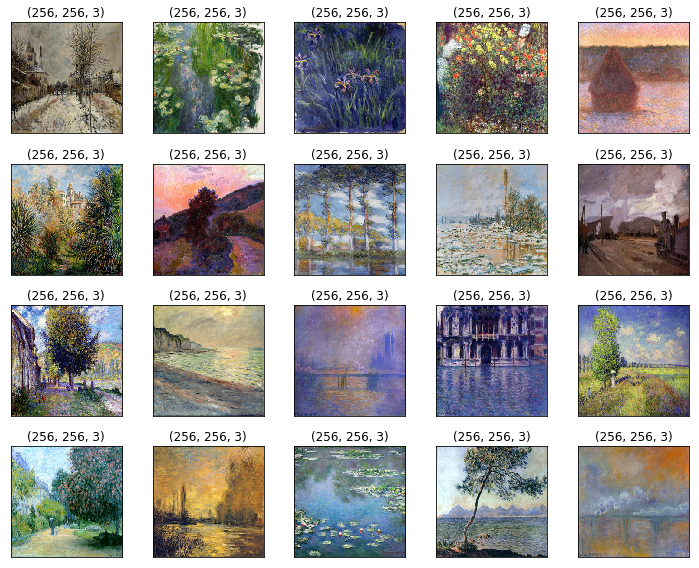

In [11]:
import numpy as np
from glob import glob
#from image_helper_cycle_gan import ImageHelper
#from cycle_gan import CycleGAN

image_helper = ImageHelper()

print("Ploting the images...")
filenames = np.array(glob('monet2photo/testA/*.jpg'))
image_helper.plot20(filenames)



In [13]:
generative_advarsial_network = CycleGAN((128, 128, 3), 10.0, image_helper)
generative_advarsial_network.train(100, 1,'monet2photo')

Build Discriminators...
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 64, 64, 64)        3136      
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 32, 32, 128)       131200    
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
instance_normalization_41 (I (None, 32, 32, 128)       2         
_________________________________________________________________
conv2d_55 (Conv2D)           (None

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


---------------------------------------------------------
******************Epoch 0 | Batch 0***************************
Generate images...
Train Discriminators...


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Train Generators...


ResourceExhaustedError: ignored